In [1]:
import numpy as np
import _pickle as pkl
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)
from argparse import Namespace
import json

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_withGT_3D9E4376CF4746EEA20DCD520218038D.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan/simple"),
 'device': 'cuda:0',
 'up_to_n_pred': 8,
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [3]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device)
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)
    
actions = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

In [4]:
from utils import load_vh_models, frame_stack
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [7]:
dict_of_models = load_models_dir(args.models_dir)
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        
        #XXX: For testing
        if path != '/home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/simple/gru_contextnotindecoder_lm_ul_v_ctex-img':
            continue
        
        model_name = path.split("/")[-1]
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        def encode(nets, x_img, x_ft, x_arm, ctx_img):
            # Prepare context data depending on model
            if model_args.context_modality != "none":
                if model_args.context_modality == "joint": 
                    ctx = torch.cat((x_ft, x_arm), dim=-1) # (n, l, f, 12)
                elif model_args.context_modality == "ft": 
                    ctx = x_ft
                elif model_args.context_modality == "arm":
                    ctx = x_arm
                ctx = ctx.float().to(device=args.device) # (n, l, f, 6)
                ctx = ctx.transpose(-1, -2)
                ctx = ctx.reshape(-1, *ctx.shape[2:])  
                    
            # Encode
            z_all_enc = []

            z_img = nets["img_enc"](x_img)
            z_all_enc.append(z_img)              
            
            context = {}
            if model_args.context_modality != "none":
                z_context = nets["context_enc"](ctx)
                z_all_enc.append(z_context)
                context["z_context"] = z_context
            if model_args.use_context_img:
                z_img_context = nets["context_img_enc"](ctx_img)
                z_all_enc.append(z_img_context)
                context["z_img_context"] = z_img_context

            # Concatenate modalities and mix
            z_cat_enc = torch.cat(z_all_enc, dim=1)
            z, mu_z, logvar_z = nets["mix"](z_cat_enc)
            var_z = torch.diag_embed(torch.exp(logvar_z))
            return z, mu_z, var_z, context
        
        if model_args.dim_x[0] == 1:
            imgs = data['img_gray']
        elif model_args.dim_x[0] == 3:
            imgs = data['img_rgb']
        
        total_len = imgs.shape[1]
        T = model_args.frame_stacks

        analysis_data[model_name] = {}
        for n_pred in range(1, args.up_to_n_pred + 1):
            analysis_data[model_name][f"{n_pred}_pred"] = {}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] = 0
            for ii in range(T, total_len - n_pred):
                x_img_i = imgs[:, (ii - 1):(ii + 1)] 
                x_img_i = frame_stack(x_img_i, frames=T)[:, 0]

                x_img_gt = imgs[:, (ii + n_pred - 1):(ii + n_pred + 1)]
                x_img_gt = frame_stack(x_img_gt, frames=T)[:, 0]
                
                if model_args.use_context_img:
                    ctx_img = x_img_i  
                else:
                    ctx_img = None
                
                x_ft_i = data['haptic'][:, ii:(ii + 1)]
                x_ft_gt = data['haptic'][:, (ii + n_pred):(ii + n_pred + 1)]

                x_arm_i = data['arm'][:, ii:(ii + 1)]                 
                x_arm_gt = data['arm'][:, (ii + n_pred):(ii + n_pred + 1)]
 
                z_gt, mu_z_gt, var_z_gt, _ = encode(nets, x_img_gt, x_ft_gt, x_arm_gt, ctx_img)
                print("GT z", z_gt[0])
                print("GT mu", mu_z_gt[0])
                print("GT var", torch.diagonal(var_z_gt[0]))

                u = actions[:, (ii + 1):(ii + n_pred + 1)]
                    
                # Encode
                z_i, mu_z_i, var_z_i, context = encode(nets, x_img_i, x_ft_i, x_arm_i, ctx_img)
                h_i = None
                
                # Predict
                for jj in range(n_pred):
                    z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                        z_t=z_i, 
                        mu_t=mu_z_i, 
                        var_t=var_z_i, 
                        u=u[:, jj], 
                        h_0=h_i, 
                        single=True
                    )
                    z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
                
                print("PRED z", z_ip1[0])
                print("PRED mu", mu_z_ip1[0])
                print("PRED var", torch.diagonal(var_z_ip1[0]))

                # Decode 
                z_all_dec = []
                z_hat = z_ip1
                z_all_dec.append(z_hat)
                
                if model_args.context_modality != "none":
                    z_all_dec.append(context["z_context"])
                if model_args.use_context_img:
                    z_all_dec.append(context["z_img_context"])
    
                z_cat_dec = torch.cat(z_all_dec, dim=1)
                x_hat = nets["img_dec"](z_cat_dec)

                x_hat = x_hat[:, 0:1].view(x_hat.shape[0], -1).cpu().numpy()
                x_img_gt = x_img_gt[:, 0:1].view(x_img_gt.shape[0], -1).cpu().numpy()
                z_hat = z_hat.cpu().numpy()
                z_gt = z_gt.cpu().numpy()

                n = x_img_gt.shape[0]

                print("prediction length", n_pred, "starting position", ii,
                    "mse img: ", (np.sum((x_img_gt - x_hat)**2) / n),
                    "mse z: ", (np.sum((z_gt - z_hat)**2) / n))
                print()

                analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] += (np.sum((x_img_gt - x_hat)**2) / n)
                analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] += (np.sum((z_gt - z_hat)**2) / n)

                batch_ssim = 0
                batch_psnr = 0
                for jj in range(n):
                    batch_ssim += ssim(
                        x_img_gt[jj].reshape(64,64), 
                        x_hat[jj].reshape(64,64), 
                        data_range=1.0
                    )
                    analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] += psnr(
                        x_img_gt[jj].reshape(64,64), 
                        x_hat[jj].reshape(64,64), 
                        data_range=1.0
                    )
                    
                analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] += (batch_ssim / n)
                analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] += (batch_psnr / n)
    
            # Average MSE/SSIM/PSNR per image 
            for k in analysis_data[model_name][f"{n_pred}_pred"]:
                analysis_data[model_name][f"{n_pred}_pred"][k] /= (total_len - n_pred - 1)
    print("DONE!")

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/simple/gru_contextnotindecoder_lm_ul_v_ctex-img
torch.Size([1600, 16, 1, 64, 64])
GT z tensor([-0.9169,  1.5113, -1.1164,  1.4737,  1.6243, -1.3026,  2.1281, -2.0384,
        -2.9841,  0.4364, -2.7738,  0.4202,  3.6035, -0.8306, -3.7937, -2.6075],
       device='cuda:0')
GT mu tensor([ 0.0579,  1.9408, -0.0391,  0.0207, -0.0285,  0.0049,  0.0069, -0.0123,
         0.2478,  0.1225, -0.0150,  0.0743,  2.2647, -3.3082,  0.0869,  0.0512],
       device='cuda:0')
GT var tensor([ 6.8903,  0.9769,  6.9484,  7.0663,  6.8663,  6.9788,  6.7655,  6.9509,
         7.9762,  7.3902,  7.0332,  7.5573, 12.6498,  1.6427,  7.1908,  6.7900],
       device='cuda:0')
PRED z tensor([ 0.0196, -4.2760, -0.0332,  0.0077, -0.0840,  0.0312,  0.0301,  0.0199,
         0.3896,  0.1562, -0.0331,  0.1082,  4.5079, -6.8452,  0.1563,  0.0192],
       device='cuda:0')
PRED mu tensor([ 0.0196, -4.2760, -0.0332,  0.0077, -0.0840,  0.0312, 

prediction length 1 starting position 7 mse img:  6.1405615234375 mse z:  52.7690771484375

GT z tensor([ 0.9366, -6.9619, -0.3413, -0.9094,  2.0634, -2.4279,  0.8314,  0.3438,
        -2.3287,  1.3019,  2.5479,  2.3334,  5.7499,  8.2513,  2.3186, -1.2416],
       device='cuda:0')
GT mu tensor([ 1.0520e-01, -5.8338e+00, -7.4095e-02,  1.0157e-01, -1.0438e-01,
         1.4394e-02,  3.4048e-02,  2.1343e-02,  3.5317e-01,  1.9613e-01,
        -2.1804e-02,  1.0878e-01,  6.7566e+00,  8.4731e+00,  1.9945e-01,
         4.9530e-03], device='cuda:0')
GT var tensor([2.6380, 0.4960, 2.5800, 2.6553, 2.5569, 2.5730, 2.5348, 2.6187, 3.2921,
        2.8583, 2.5967, 2.8286, 4.7348, 0.4502, 2.8014, 2.5067],
       device='cuda:0')
PRED z tensor([ 0.0801,  1.9748, -0.0436,  0.0844, -0.1096,  0.0492,  0.0536,  0.0206,
         0.3447,  0.1746,  0.0175,  0.0950,  6.0788,  9.1205,  0.1724,  0.0198],
       device='cuda:0')
PRED mu tensor([ 0.0801,  1.9748, -0.0436,  0.0844, -0.1096,  0.0492,  0.0536,  0.0206

prediction length 1 starting position 14 mse img:  25.461591796875 mse z:  143.9866796875

torch.Size([1600, 16, 1, 64, 64])
GT z tensor([-3.8130e-01,  3.4712e-01, -1.4431e+00, -1.9232e+00,  1.6489e+00,
        -1.5475e+00,  7.4799e-02, -1.8410e-03,  1.4474e+00, -3.5512e+00,
        -7.6644e-01, -2.5714e+00,  4.6558e+00, -3.9304e+00,  1.1561e+00,
         2.7610e+00], device='cuda:0')
GT mu tensor([ 7.0518e-02,  9.6712e-01, -4.5540e-02,  2.0449e-02, -5.2917e-02,
         9.3766e-03,  1.9453e-02, -3.9564e-03,  3.5853e-01,  1.7058e-01,
        -2.1371e-02,  1.0726e-01,  3.5467e+00, -4.4281e+00,  1.2960e-01,
         5.3069e-02], device='cuda:0')
GT var tensor([4.4575, 1.0204, 4.4918, 4.5844, 4.4222, 4.4997, 4.3495, 4.5013, 5.4513,
        4.8794, 4.5526, 4.9633, 9.7283, 1.7662, 4.6984, 4.3447],
       device='cuda:0')
PRED z tensor([ 0.0356, -8.9416, -0.0304,  0.0458, -0.0949,  0.0300,  0.0317,  0.0262,
         0.4065,  0.1572, -0.0435,  0.1312,  7.9268, -6.2755,  0.1953,  0.0307],
    

prediction length 2 starting position 7 mse img:  7.100820922851563 mse z:  60.3624658203125

GT z tensor([ 1.8733,  1.4899, -0.6538,  1.5621, -1.0806,  0.4704, -4.1823, -0.2762,
        -0.4927,  0.7846, -0.5362,  0.3060,  7.3967, 10.9235, -0.1184,  0.4213],
       device='cuda:0')
GT mu tensor([ 1.0449e-01,  2.2006e+00, -6.9678e-02,  1.0045e-01, -1.0632e-01,
         4.2973e-02,  3.4809e-02,  1.7185e-02,  2.9433e-01,  1.7189e-01,
         1.1526e-02,  7.7499e-02,  8.0379e+00,  1.2059e+01,  1.7541e-01,
        -1.3225e-04], device='cuda:0')
GT var tensor([2.3114, 0.1921, 2.2647, 2.3140, 2.2261, 2.2381, 2.2196, 2.2773, 2.9096,
        2.4805, 2.2414, 2.4831, 3.4720, 0.8502, 2.4687, 2.1920],
       device='cuda:0')
PRED z tensor([ 0.0661, 10.1979, -0.0503,  0.0347, -0.1175,  0.0814,  0.0332,  0.0112,
         0.3888,  0.1841,  0.0401,  0.1056,  7.6983,  6.4067,  0.1703,  0.0199],
       device='cuda:0')
PRED mu tensor([ 0.0661, 10.1979, -0.0503,  0.0347, -0.1175,  0.0814,  0.0332,  0.01

prediction length 2 starting position 13 mse img:  30.1265380859375 mse z:  111.41626953125

torch.Size([1600, 16, 1, 64, 64])
GT z tensor([-2.2892,  1.9040, -1.8015,  1.8291,  3.0427, -1.5274,  2.0019, -2.3688,
         1.4294,  1.4595, -2.6033,  3.4554,  0.8374, -3.1632,  2.4772,  3.2416],
       device='cuda:0')
GT mu tensor([ 7.4634e-02, -2.6330e-01, -4.8023e-02,  1.7986e-02, -6.4574e-02,
         1.0793e-02,  2.7962e-02,  1.8543e-03,  4.2381e-01,  1.9722e-01,
        -2.9373e-02,  1.3149e-01,  4.1263e+00, -5.3718e+00,  1.5603e-01,
         5.6524e-02], device='cuda:0')
GT var tensor([3.1162, 0.9515, 3.1376, 3.2140, 3.0726, 3.1327, 3.0245, 3.1461, 3.9671,
        3.4675, 3.1839, 3.5065, 8.2060, 2.1574, 3.3092, 3.0088],
       device='cuda:0')
PRED z tensor([  0.0737, -12.8585,  -0.0577,   0.0988,  -0.1000,   0.0228,   0.0280,
          0.0363,   0.3775,   0.1721,  -0.0552,   0.1366,   8.8618,   2.2863,
          0.2303,   0.0178], device='cuda:0')
PRED mu tensor([  0.0737, -12.8585

prediction length 3 starting position 6 mse img:  6.206367797851563 mse z:  60.2765576171875

GT z tensor([ 0.1278,  2.9507,  1.0307, -1.0828, -1.4199, -0.0158, -0.5052,  3.2827,
        -0.2567,  0.3805, -0.4598,  1.0270,  8.3002, 11.1693, -0.3966,  0.1100],
       device='cuda:0')
GT mu tensor([ 1.0702e-01,  2.7655e+00, -6.8581e-02,  1.1043e-01, -1.0563e-01,
         4.7707e-02,  2.7068e-02,  1.3956e-02,  2.5675e-01,  1.5216e-01,
         1.0567e-02,  6.6462e-02,  9.1336e+00,  1.3126e+01,  1.6536e-01,
        -1.7181e-03], device='cuda:0')
GT var tensor([2.1214, 0.1912, 2.0696, 2.1193, 2.0414, 2.0470, 2.0252, 2.0840, 2.6976,
        2.2826, 2.0503, 2.2842, 2.9599, 0.8781, 2.2744, 2.0084],
       device='cuda:0')
PRED z tensor([ 7.5621e-02,  1.0408e+01, -5.3720e-02,  5.5511e-02, -1.2802e-01,
         9.1302e-02,  3.1394e-02,  9.8405e-03,  3.7513e-01,  1.8288e-01,
         4.2074e-02,  1.0450e-01,  9.5460e+00,  8.3288e+00,  1.7950e-01,
         2.1510e-02], device='cuda:0')
PRED mu ten

prediction length 3 starting position 12 mse img:  34.03960205078125 mse z:  131.91138671875

torch.Size([1600, 16, 1, 64, 64])
GT z tensor([ 0.5191, -4.7528, -0.4438, -0.4304,  1.5122,  1.4302,  3.1516,  0.0074,
        -0.8637, -0.9005,  2.6938,  1.2368,  4.3899, -5.9360, -1.2011,  1.5690],
       device='cuda:0')
GT mu tensor([ 6.5305e-02, -5.1412e+00, -4.3387e-02,  1.6935e-02, -6.6683e-02,
         5.2014e-03,  2.9206e-02,  1.2591e-02,  3.8306e-01,  1.7344e-01,
        -4.8837e-02,  1.3465e-01,  4.3840e+00, -7.2464e+00,  1.5925e-01,
         4.0540e-02], device='cuda:0')
GT var tensor([2.0869, 0.6591, 2.0855, 2.1575, 2.0339, 2.0777, 2.0101, 2.1036, 2.7483,
        2.3639, 2.1262, 2.3507, 7.3941, 3.9111, 2.2320, 1.9944],
       device='cuda:0')
PRED z tensor([ 1.0928e-01, -9.6886e+00, -7.8805e-02,  1.3162e-01, -1.1539e-01,
         3.0681e-02,  3.3560e-02,  3.9382e-02,  3.7614e-01,  1.9063e-01,
        -4.0417e-02,  1.2968e-01,  8.9849e+00,  1.1087e+01,  2.3934e-01,
         1.1008e

prediction length 4 starting position 6 mse img:  6.515807495117188 mse z:  59.4403662109375

GT z tensor([-1.0835, 10.6172, -0.4366, -1.2470,  0.4251,  0.8645, -0.6701,  0.2051,
         1.7209, -1.8260, -0.6658,  3.0646, 12.0252,  8.0345,  1.3653,  0.2734],
       device='cuda:0')
GT mu tensor([ 8.3491e-02,  1.0202e+01, -6.0885e-02,  6.7126e-02, -1.2319e-01,
         8.1066e-02,  3.1255e-02,  5.0852e-03,  3.0904e-01,  1.6789e-01,
         3.4434e-02,  8.8187e-02,  1.0087e+01,  9.4364e+00,  1.6672e-01,
         6.6085e-03], device='cuda:0')
GT var tensor([2.0343, 0.2683, 2.0107, 2.0325, 1.9608, 1.9750, 1.9638, 2.0124, 2.6030,
        2.1817, 1.9608, 2.2131, 2.6331, 0.4460, 2.1887, 1.9256],
       device='cuda:0')
PRED z tensor([ 2.1042e-02,  1.5425e+01, -2.9223e-02, -5.8876e-03, -1.4864e-01,
         1.0105e-01,  3.1440e-02, -2.3258e-02,  3.4492e-01,  1.6389e-01,
         6.0940e-02,  1.1335e-01,  1.0442e+01, -2.5374e+00,  1.4532e-01,
         2.7715e-02], device='cuda:0')
PRED mu ten

prediction length 5 starting position 1 mse img:  14.4994873046875 mse z:  294.592421875

GT z tensor([ -0.3779, -14.5871,  -0.0270,  -1.4107,  -4.0928,  -0.9850,   0.3567,
         -2.8458,  -2.8065,   0.8237,  -1.1104,  -0.1608,  11.5497,   2.6721,
          1.2999,   1.6790], device='cuda:0')
GT mu tensor([ 7.8414e-02, -1.4440e+01, -4.7955e-02,  1.1346e-01, -6.8673e-02,
        -7.5129e-03,  1.6300e-03,  2.2031e-02,  1.7017e-01,  7.8544e-02,
        -7.7831e-02,  9.3780e-02,  7.8919e+00,  2.4197e+00,  1.5128e-01,
         4.9489e-03], device='cuda:0')
GT var tensor([2.2949, 1.2825, 2.2359, 2.3358, 2.2131, 2.2462, 2.1708, 2.2786, 2.9777,
        2.5672, 2.3015, 2.4904, 5.7255, 0.5542, 2.4504, 2.1623],
       device='cuda:0')
PRED z tensor([ 1.1428e-01,  2.3845e+00, -6.7342e-02,  1.3234e-01, -1.2791e-01,
         7.4918e-02,  2.9322e-02,  2.0887e-02,  2.9956e-01,  1.5637e-01,
         1.3521e-02,  8.7862e-02,  1.1603e+01,  1.5555e+01,  2.0036e-01,
         1.6875e-02], device='cuda:0'

prediction length 5 starting position 7 mse img:  8.803804931640625 mse z:  85.658515625

GT z tensor([ 0.1945, 15.1175, -1.6930,  0.3563, -0.7275,  1.6338, -1.3466, -0.2480,
         0.7581, -2.4146,  0.1828, -1.3934,  9.5696, -3.3898,  1.0630,  0.2927],
       device='cuda:0')
GT mu tensor([ 2.4158e-02,  1.6385e+01, -3.5528e-02, -8.0226e-03, -1.5060e-01,
         9.7902e-02,  3.0135e-02, -1.7251e-02,  3.4120e-01,  1.7226e-01,
         5.5704e-02,  1.2903e-01,  1.1241e+01, -3.7437e+00,  1.4763e-01,
         1.5507e-02], device='cuda:0')
GT var tensor([1.8370, 0.9458, 1.8627, 1.8611, 1.7684, 1.8138, 1.8107, 1.8500, 2.4434,
        2.0265, 1.8199, 2.0470, 2.1578, 0.0818, 1.9956, 1.7404],
       device='cuda:0')
PRED z tensor([ 6.4495e-04,  4.5608e+00, -8.3331e-03,  2.4878e-03, -1.4635e-01,
         8.2525e-02,  4.0476e-02, -2.1381e-02,  3.3144e-01,  1.3196e-01,
         2.0552e-02,  1.1837e-01,  1.2150e+01, -1.4364e+01,  1.5428e-01,
         5.2106e-02], device='cuda:0')
PRED mu tensor(

prediction length 6 starting position 3 mse img:  15.5498486328125 mse z:  236.8565625

GT z tensor([-3.7457,  3.7146, -0.5463,  1.3477, -1.2553,  0.8067, -0.1613, -0.4892,
         1.3385,  1.2707, -0.9002,  0.9925,  6.7131, 14.4944,  1.6842, -3.2053],
       device='cuda:0')
GT mu tensor([ 1.2343e-01,  3.0398e+00, -7.3834e-02,  1.2088e-01, -1.2702e-01,
         6.2319e-02,  2.7196e-02,  1.4727e-02,  2.6380e-01,  1.5960e-01,
         2.2515e-03,  7.5028e-02,  1.0529e+01,  1.4431e+01,  1.8085e-01,
         6.1007e-03], device='cuda:0')
GT var tensor([1.8177, 0.3503, 1.7695, 1.8152, 1.7463, 1.7527, 1.7222, 1.7838, 2.3693,
        1.9768, 1.7537, 1.9647, 2.4696, 0.5580, 1.9705, 1.7122],
       device='cuda:0')
PRED z tensor([ 6.7799e-02,  1.3681e+01, -5.3647e-02,  5.6510e-02, -1.5347e-01,
         1.1260e-01,  3.0218e-02,  3.2312e-03,  3.8560e-01,  2.0025e-01,
         5.3162e-02,  1.2374e-01,  1.2068e+01,  7.4796e+00,  1.9081e-01,
         2.4683e-02], device='cuda:0')
PRED mu tensor([ 

prediction length 6 starting position 9 mse img:  30.37701416015625 mse z:  157.3966796875

torch.Size([1600, 16, 1, 64, 64])
GT z tensor([  2.5461, -12.5317,  -0.6618,   1.0829,  -0.4968,  -0.3876,  -0.2587,
          0.5713,  -2.9448,   0.9584,  -2.0435,   2.1690,   9.6827,   8.1433,
          2.5398,   1.9976], device='cuda:0')
GT mu tensor([ 1.0600e-01, -1.2263e+01, -6.6105e-02,  1.3329e-01, -9.7552e-02,
         7.8233e-03,  8.7912e-03,  2.0636e-02,  1.5921e-01,  1.1016e-01,
        -6.4033e-02,  8.3205e-02,  9.0536e+00,  8.0556e+00,  1.6854e-01,
         1.3610e-03], device='cuda:0')
GT var tensor([1.9289, 1.1400, 1.8662, 1.9501, 1.8556, 1.8764, 1.8157, 1.9038, 2.5247,
        2.1525, 1.9110, 2.0889, 4.0165, 0.4069, 2.0736, 1.8080],
       device='cuda:0')
PRED z tensor([ 4.2303e-02,  1.7120e+01, -4.0977e-02,  1.7492e-02, -1.6414e-01,
         1.1866e-01,  3.2214e-02, -1.4541e-02,  3.8466e-01,  1.9707e-01,
         6.6754e-02,  1.2962e-01,  1.2185e+01,  1.4327e+00,  1.7541e-01,
 

prediction length 7 starting position 6 mse img:  8.039833984375 mse z:  71.84640625

GT z tensor([  0.3397,  13.5995,   0.5540,  -1.0002,   0.6574,  -0.8722,   0.0503,
         -1.0305,   1.5454,   0.3826,   1.1369,  -1.7000,  14.8879, -11.5051,
         -1.8081,  -2.9355], device='cuda:0')
GT mu tensor([ 1.8003e-03,  1.2766e+01, -1.3454e-02, -8.5006e-03, -1.5793e-01,
         9.8446e-02,  2.7492e-02, -2.4017e-02,  2.9280e-01,  1.2567e-01,
         4.5657e-02,  1.2770e-01,  1.3301e+01, -1.1576e+01,  1.3331e-01,
         3.4119e-02], device='cuda:0')
GT var tensor([1.6958, 0.7598, 1.7271, 1.7319, 1.6286, 1.6861, 1.6787, 1.7175, 2.3172,
        1.9235, 1.6972, 1.8942, 2.3199, 0.1443, 1.8578, 1.6022],
       device='cuda:0')
PRED z tensor([-1.1697e-02, -5.1696e+00,  3.8432e-04,  4.7348e-02, -1.3425e-01,
         7.6334e-02,  2.5309e-02, -1.7284e-02,  2.5136e-01,  6.9858e-02,
        -1.3995e-02,  1.0873e-01,  1.5907e+01, -1.6768e+01,  1.5584e-01,
         5.7283e-02], device='cuda:0')
PR

prediction length 8 starting position 4 mse img:  24.15561279296875 mse z:  108.22353515625

GT z tensor([ 1.0700, 16.9758, -2.7551,  0.5071,  2.0064, -0.8161, -1.7137, -0.8759,
        -0.8061, -1.3155, -0.2260,  0.8437, 14.1931, -5.3349, -1.0783, -0.6111],
       device='cuda:0')
GT mu tensor([ 1.0867e-04,  1.7506e+01, -1.5574e-02,  4.4386e-03, -1.4390e-01,
         1.0757e-01,  6.0806e-03, -4.1276e-02,  1.4627e-01,  7.4918e-02,
         6.4219e-02,  9.1171e-02,  1.4174e+01, -5.4396e+00,  8.7274e-02,
         2.1069e-02], device='cuda:0')
GT var tensor([1.7746, 1.1476, 1.7941, 1.7952, 1.7107, 1.7460, 1.7505, 1.7836, 2.3672,
        1.9662, 1.7492, 1.9762, 1.6257, 0.1545, 1.9366, 1.6824],
       device='cuda:0')
PRED z tensor([-4.4191e-03,  5.3042e+00, -5.7039e-03,  7.5162e-03, -1.6425e-01,
         9.4305e-02,  4.2568e-02, -2.6497e-02,  3.2610e-01,  1.3513e-01,
         2.5558e-02,  1.2833e-01,  1.4345e+01, -1.6455e+01,  1.6264e-01,
         6.1418e-02], device='cuda:0')
PRED mu tens

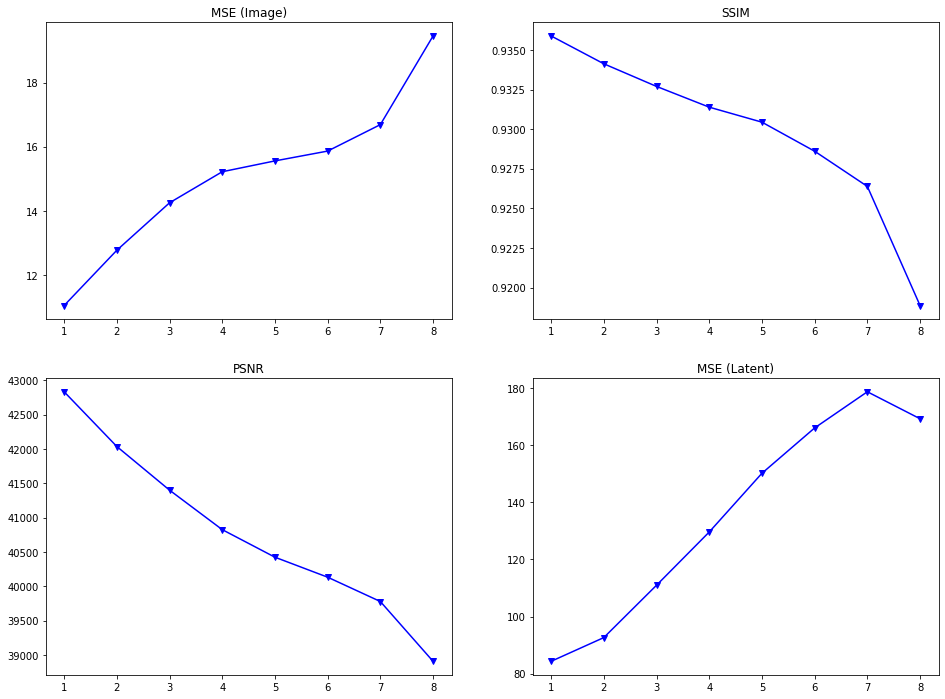

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(16,12))

def add_data_to_plot(name, data):
    properties = name.split("_")
    
    # Map model properties to line properties here
    if "vha" in properties:
        color = "r"
    else:
        color = "b"
        
#     if "4step" in properties:
#         linestyle = "-."
#     else:
#         linestyle = "-"
        
    if "nl" in properties:
        marker = "o"
    else:
        marker = "v"
    
    plot_data = {'MSE_x': [], 'SSIM': [], 'PSNR': [], "MSE_z": []}
    for k, v in data.items():
        plot_data['MSE_x'].append(v['MSE_x'])
        plot_data['SSIM'].append(v['SSIM'])
        plot_data['PSNR'].append(v['PSNR'])
        plot_data['MSE_z'].append(v['MSE_z'])

    axs[0,0].plot(
        list(range(1, len(plot_data['MSE_x']) + 1)), 
        plot_data['MSE_x'],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    axs[0,1].plot(
        list(range(1, len(plot_data['SSIM']) + 1)), 
        plot_data['SSIM'],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    axs[1,0].plot(
        list(range(1, len(plot_data['PSNR']) + 1)), 
        plot_data['PSNR'],
        color=color,
        linestyle=linestyle,
        marker=marker
    )
    axs[1,1].plot(
        list(range(1, len(plot_data['MSE_z']) + 1)), 
        plot_data['MSE_z'],
        color=color,
        linestyle=linestyle,
        marker=marker
    )

axs[0,0].set_title("MSE (Image)")
axs[0,1].set_title("SSIM")
axs[1,0].set_title("PSNR")
axs[1,1].set_title("MSE (Latent)")

for k, v in analysis_data.items():
    add_data_to_plot(k, v)